# KLT PNP TD 3D analysis 
## Par: Julian CAIPA.
### Pour: Computer Vision, M. ABABSA.

### Introduction (en français):

Dans ce projet, nous allons explorer les méthodes de suivi 3D et d’estimation de pose appliquées dans le domaine de la vision par ordinateur. L'objectif est de suivre en temps réel la position et l'orientation (pose) d'un objet 3D à partir d'une séquence vidéo, en utilisant des techniques avancées de traitement d'images. Ce travail se concentre particulièrement sur l'utilisation de l’algorithme KLT (Kanade-Lucas-Tomasi) pour le suivi des points d'intérêt en 2D et sur l'algorithme Ransac-PnP pour l’estimation de la pose de la caméra, qui permet de projeter un modèle 3D de l'objet dans l'image.

#### Contexte et applications:

L'estimation de pose 3D est essentielle dans les domaines de la réalité augmentée et de la localisation 3D. Elle permet de superposer un modèle virtuel à un environnement réel en ajustant continuellement la vue virtuelle en fonction des mouvements de la caméra. Cette technique repose sur l'identification des correspondances entre des points 2D dans l'image et leurs positions en 3D dans l'espace, permettant ainsi de calculer l’orientation et la position de la caméra.

#### Méthodologie:

Le processus global est divisé en plusieurs étapes:
1. **Modélisation de l’objet 3D**: Création d'un modèle 3D de la boîte et définition des points de référence en 3D.
2. **Calibration de la caméra**: Utilisation des paramètres intrinsèques de la caméra pour la calibration.
3. **Suivi des points en 2D (KLT)**: Suivi des coins de la boîte dans chaque image de la séquence vidéo pour obtenir les déplacements en 2D.
4. **Estimation de la pose (PnP)**: Estimation de la position et de l'orientation de la caméra en utilisant l’algorithme PnP avec RANSAC pour éviter les erreurs dues aux correspondances aberrantes.
5. **Projection du modèle 3D**: Projection des points 3D dans l'image pour visualiser la position estimée de la boîte en temps réel.

Ce projet nécessite une compréhension approfondie des concepts de base du suivi d'image et de l'algorithme KLT, ainsi que de l'estimation de pose via les correspondances 2D-3D, qui sont au cœur de l'algorithme PnP. L’implémentation se fera en utilisant la bibliothèque OpenCV.

Ce notebook détaillera chaque étape de ce processus, de la modélisation à la visualisation, en montrant les résultats de suivi et d’estimation de pose en temps réel, avec une analyse de l'erreur de reprojection pour évaluer la précision du suivi.

En outre, ce processus sera réalisé de deux manières différentes, d'abord avec la possibilité pour l'utilisateur de sélectionner les points, ce qui est sujet à erreur, et ensuite avec les points prédéfinis comme coordonnées (mesurées approximativement), puis les erreurs seront comparées sur la durée de la vidéo. 

## Définitions de paramètres
Dans cette section du code, on définit les paramètres essentiels pour le suivi 3D de l'objet, qui sont communs aux deux méthodes (sélection manuelle et coordonnées prédéfinies). Ces paramètres incluent les coordonnées 3D des points de référence de l'objet, les paramètres intrinsèques de la caméra, les coefficients de distorsion, et une variable pour stocker les points 2D sélectionnés dans l'image. Ces éléments sont indispensables pour la projection et l'estimation de pose de l'objet dans la scène.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Coordonnées 3D précises des coins de la boîte
obj_points = np.array([
    [0, 90, 0], [125, 90, 0], [125, 90, 70], [0, 90, 70],
    [0, 0, 0], [125, 0, 0], [125, 0, 70], [0, 0, 70]
], dtype=np.float32).reshape((-1, 1, 3)) * 1e-3

# Matrice intrinsèque de la caméra
cam_matrix = np.array([
    [606.229, 0, 320.046],
    [0, 606.719, 238.926],
    [0, 0, 1]
], dtype=np.float32)

# Coefficients de distorsion de la caméra, supposés ici à zéro pour simplifier le modèle, en indiquant qu’il n’y a pas de distorsion dans l’image.
dist_coeffs = np.zeros((4, 1), dtype=np.float32) 

# Stock des points 2D sélectionnés dans l'image ou prédéfinis
img_points = []

### Fonction *draw_box_lines*
Fonction utilisée pour dessiner la structure de la boîte en reliant les points projetés dans l'image par des lignes. 
On prend les paires qui constituent les connexions entre les coins et on les itère pour générer les débuts et les fins de ligne. La fonction cv2 génère ensuite les lignes, de couleur grise (88,88,88) et d'épaisseur 2. 

In [16]:
def draw_box_lines(img, points):
    points = points.reshape(-1, 2)
    edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 4), (1, 5), (2, 6), (3, 7), (4, 5), (5, 6), (6, 7), (7, 4)]
    for start, end in edges:
        pt1 = tuple(points[start].astype(int))
        pt2 = tuple(points[end].astype(int))
        cv2.line(img, pt1, pt2, (88, 88, 88), 2)

## Algorithme avec sélection manuelle des points:
Dans un premier temps, l'algorithme sera exécuté en permettant à l'utilisateur, par le biais d'un clic, de sélectionner les 4 coins, puis en appliquant la méthode combinée KLT-PNP.

### Capture du vidéo
La vidéo est lue et la première image est extraite pour la sélection des points. 

In [17]:
cap = cv2.VideoCapture("box_video_data_2.avi")
success, old_frame = cap.read() # Premier cadre pour sélection des points

### Sélection des points
On configure le code pour permettre à l'utilisateur de sélectionner manuellement quatre points dans le premier cadre de la vidéo, qui correspondent aux coins de la boîte dans l'image. Ces points serviront de référence pour le suivi et l'estimation de pose de l'objet.
- La fonction *select_points* comporte un *if* qui est exécuté lorsqu'un clic gauche est détecté. Elle fonctionne jusqu'à ce que 4 points soient cliqués, les valeurs du point sélectionné dans l'image étant alors enregistrées et dessinées sous forme de cercles sur l'image. Ensuite, lorsque les 4 clics sont atteints, la fenêtre est fermée. 

- Ensuite, la fonction est appelée à l'intérieur d'une *MouseCallback* et une boucle *while* est créée pour maintenir la fenêtre ouverte jusqu'à ce que les 4 points soient sélectionnés.

- Enfin, les informations sont stockées dans un tableau, la première image est convertie en une image en niveaux de gris (processus conventionnel de suivi d'image) et les premiers points sont stockés sous la forme *p0*.

In [ ]:
def select_points(event, x, y, flags, param):
    global img_points
    if event == cv2.EVENT_LBUTTONDOWN and len(img_points) < 4:
        img_points.append((x, y))
        cv2.circle(param, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Selection des points", param)
        
        # Fermeture après 4 clics
        if len(img_points) == 4:
            cv2.destroyWindow("Selection des points")

# Premier cadre et Clic event
cv2.imshow("Selection des points", old_frame)
cv2.setMouseCallback("Selection des points", select_points, old_frame)

# Boucle pour atteindre les 4 points
while len(img_points) < 4:
    cv2.waitKey(1)

# Conversion des points
img_points = np.array(img_points, dtype=np.float32).reshape(-1, 1, 2)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = img_points

### Boucle de suivi 3D
On configure et exécute le suivi des points en utilisant le flux optique KLT (Kanade-Lucas-Tomasi) pour chaque cadre de la vidéo. Ensuite, nous estimons la pose de la caméra et calculons l'erreur de reprojection pour évaluer la précision du suivi en temps réel.

Les paramètres du flux optique, la taille de la fenêtre et les critères d'itération de la pyramide sont configurés. 

In [19]:
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

Liste vide pour stocker les valeurs d'erreur de reprojection pour chaque cadre.

In [20]:
error_list_manual = []

Boucle *while* chaque cadre de la vidéo jusqu'à la fin. 
- *cap.read()* capture le cadre actuel, et si la lecture échoue, la boucle se termine.

- Chaque image est convertie en niveaux de gris.

- *cv2.calcOpticalFlowPyrLK* applique l'algorithme KLT pour calculer les nouvelles positions des points suivis dans le cadre actuel. *status* indique quels points ont été suivis avec succès.

- *cv2.solvePnP* pour estimer la pose de la caméra en fonction des quatre points good_new et leurs coordonnées 3D correspondantes. *rvecs* et *tvecs* sont respectivement les vecteurs de rotation et de translation qui représentent la pose de la caméra.

- Si la pose est estimée avec succès, on project les points 3D de la boîte (*obj_points*) dans le cadre actuel et les dessine en utilisant *draw_box_lines* pour visualiser la structure de la boîte dans l'image.

- On sélectionne les quatre points projetés qui correspondent aux points de référence et calcule l'erreur de reprojection entre les points projetés et les points suivis (*good_new*). *mean_error* est la moyenne de cette erreur pour le cadre actuel.

- On ajoute la valeur de mean_error à error_list_manual pour stocker l'erreur moyenne de chaque cadre après on affiche l'erreur de reprojection sur le cadre en cours, ce qui permet de visualiser en temps réel la précision du suivi.

- Boucle *if* pour dessiner des cercles rouges autour des points suivis (good_new) dans le cadre pour marquer leur position actuelle.

- On affiche le cadre actuel avec la boîte projetée et les informations d'erreur dans une fenêtre. Si l'utilisateur appuie sur la touche *q*, la boucle se termine, permettant d'arrêter la lecture de la vidéo.

- On met à jour *old_gray* avec le cadre actuel pour l'utiliser comme cadre précédent au prochain tour de boucle, et *p0* avec les nouvelles positions des points suivis.

- Enfin, on libère la capture vidéo et ferme toutes les fenêtres d'affichage.

In [ ]:
# Début du boucle
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    # Niveaux de gris pour tous les frames    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # KLT
    p1, status, error = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Filtrage des points
    good_new = p1[status == 1]
    good_old = p0[status == 1]

    # PnP 
    success_pnp, rvecs, tvecs = cv2.solvePnP(obj_points[[3, 2, 6, 7]], good_new, cam_matrix, dist_coeffs)
    
    if success_pnp:
        # Projection des points et dessiner les lignes
        points_projected, _ = cv2.projectPoints(obj_points, rvecs, tvecs, cam_matrix, dist_coeffs)
        draw_box_lines(frame, points_projected)

        # Sélection des points de réference
        points_projected_selected = points_projected[[3, 2, 6, 7]].reshape(-1, 2)

        # Error
        error_reprojection = np.linalg.norm(good_new - points_projected_selected, axis=1)
        mean_error = np.mean(error_reprojection)
        error_list_manual.append(mean_error)
        
        # Visualisation de l'erreur sur l'écran
        cv2.putText(frame, f"Erreur de Projection: {mean_error:.2f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    # Dessiner les points actuels
    for i, new in enumerate(good_new):
        a, b = new.ravel()
        frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    cv2.imshow("Suivi de la boite", frame)
    
    # Sortie avec 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    
    # Actualisation du cadre et points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Finalisation avec Release
cap.release()
cv2.destroyAllWindows()

L'erreur moyenne est calculée et la valeur est affichée.

In [22]:
mean_error_total_manual = np.mean(error_list_manual) 
print(f"\nErreur de projection moyenne sur l'ensemble de la séquence: {mean_error_total_manual:.2f}")


Erreur de projection moyenne sur l'ensemble de la séquence: 3.53


## Algorithme avec coordonnées prédéfinies
Pour le code avec des coordonnées prédéfinies, la même procédure est appliquée, à la seule différence que les coordonnées des points sont saisies au-dessus de la boîte pour éviter l'erreur de sélection de l'utilisateur, et une section dédiée à la sortie du résultat de la projection sous forme de vidéo (qui est stockée dans le dossier où le code est exécuté) est introduite.

In [ ]:
# Capture du vidéo
cap = cv2.VideoCapture("box_video_data_2.avi")
success, old_frame = cap.read() # Premier cadre pour sélection des points
 
# Points 2D initiaux de l'image (coins de la boîte dans la première image)
img_points = np.array([
    [173, 246], [417, 234], [401, 354], [191, 365]
], dtype=np.float32)

# Configuration du vidéo de sortie (Résultat final)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_video = cv2.VideoWriter("output_tracking_video_predefini.avi", cv2.VideoWriter_fourcc(*'XVID'), 25, (frame_width, frame_height))

# Conversion des points
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = img_points.reshape(-1, 1, 2)

# Paramètres du flux optique
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List pour stocker l'erreur
error_list_predefinido = []

# Début du boucle
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    
    # Niveaux de gris pour tous les frames
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # KLT
    p1, status, error = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Filtrage des points
    good_new = p1[status == 1]
    good_old = p0[status == 1]

    # PnP 
    success_pnp, rvecs, tvecs = cv2.solvePnP(obj_points[[3, 2, 6, 7]], good_new, cam_matrix, dist_coeffs)
    
    if success_pnp:
        # Projection des points et dessiner les lignes
        points_projected, _ = cv2.projectPoints(obj_points, rvecs, tvecs, cam_matrix, dist_coeffs)
        draw_box_lines(frame, points_projected)

        # Sélection des points de réference
        points_projected_selected = points_projected[[3, 2, 6, 7]].reshape(-1, 2)

        # Error
        error_reprojection = np.linalg.norm(good_new - points_projected_selected, axis=1)
        mean_error = np.mean(error_reprojection)
        error_list_predefinido.append(mean_error)
        
        # Visualisation de l'erreur sur l'écran
        cv2.putText(frame, f"Erreur de projection: {mean_error:.2f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    # Dessiner les points actuels
    for i, new in enumerate(good_new):
        a, b = new.ravel()
        frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    # Écriture de l'image dans la vidéo de sortie
    output_video.write(frame)

    cv2.imshow("Suivi de la boite", frame)
    
    # Sortie avec 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    
    # Actualisation du cadre et points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Finalisation avec Release
cap.release()
output_video.release()
cv2.destroyAllWindows()

# Calculer et afficher les valeurs d'erreur
mean_error_total_predefinido = np.mean(error_list_predefinido)  # Calcular el error promedio

print(f"\nErreur de projection moyenne sur l'ensemble de la séquence: {mean_error_total_predefinido:.2f}")


Erreur de projection moyenne sur l'ensemble de la séquence: 2.32


## Résultats, comparaison et conclusions
Pour comparer les deux algorithmes, un graphique est généré qui montre l'erreur sur l'ensemble de l'assemblage vidéo, ainsi que les erreurs moyennes au cours de l'algorithme selon chaque méthode (avec ou sans coordonnées prédéfinies).

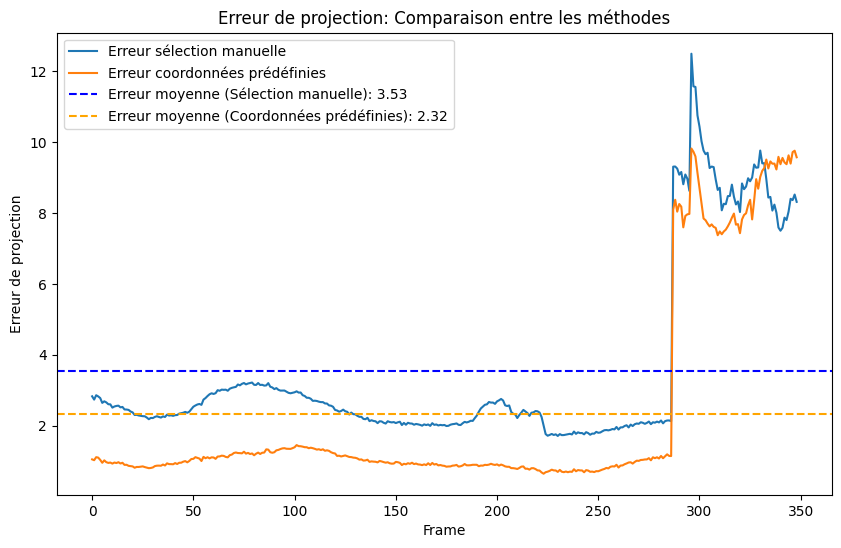

In [24]:
# Graphique des erreurs
plt.figure(figsize=(10, 6))
plt.plot(error_list_manual, label="Erreur sélection manuelle")
plt.plot(error_list_predefinido, label="Erreur coordonnées prédéfinies")

# Calcul des erreurs moyennes
mean_error_total_manual = np.mean(error_list_manual)
mean_error_total_predefinido = np.mean(error_list_predefinido)

# Ajouter des lignes horizontales pour les erreurs moyennes
plt.axhline(mean_error_total_manual, color='blue', linestyle='--', label=f"Erreur moyenne (Sélection manuelle): {mean_error_total_manual:.2f}")
plt.axhline(mean_error_total_predefinido, color='orange', linestyle='--', label=f"Erreur moyenne (Coordonnées prédéfinies): {mean_error_total_predefinido:.2f}")

# Format du graphique
plt.xlabel("Frame")
plt.ylabel("Erreur de projection")
plt.title("Erreur de projection: Comparaison entre les méthodes")
plt.legend()
plt.show()


## Conclusion final
À la fin de la vidéo, les erreurs sont déclenchées en raison de l'angle sous lequel la vidéo est prise, ce qui complique l'algorithme de suivi et nécessite un perfectionnement pour s'adapter à ces changements. S'il est vrai que la fin de l'algorithme avec des coordonnées prédéfinies subit plus de changements et des valeurs d'erreur plus élevées, l'erreur moyenne reste généralement inférieure à l'algorithme avec sélection manuelle, ceci est dû à l'erreur humaine associée à la prise des points, qui peuvent ne pas être pris précisément au pixel d'angle, ce qui fait varier l'algorithme, ceci évidemment en tenant compte du fait que les coordonnées prédéfinies ont été prises à la main et ont donc une légère imprécision à la fin. 
Cela permet de conclure que la méthode peut être plus efficace si les coordonnées sont ajustées de manière appropriée (c'est pourquoi il a été décidé d'exporter la vidéo de l'algorithme avec des coordonnées prédéfinies) et que les changements soudains dans les images génèrent des complications dans l'algorithme. 